## Import Dependencies

In [25]:
import numpy as np
import pandas as pd
from sklearn.tree import (
    DecisionTreeRegressor,
)
import pickle
import os
from datetime import datetime
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use("ggplot")
sns.set(font_scale=1.2)


## Load Dataset

## Feature Extraction

In [26]:
def extract_features(df: pd.DataFrame) -> dict:
    """
    Extract key characteristics from the input DataFrame relevant for imputation.
    Characteristics extracted:
    - length: number of rows in the DataFrame.
    - missing_rate: overall fraction of missing values.
    - has_trend: binary indicator if a trend exists in the first numeric column.
    - has_seasonality: binary indicator based on inferred frequency.
    Parameters:
    - df: pd.DataFrame containing the time-series data.
    Returns:
    - features: dict with keys 'length', 'missing_rate', 'has_trend', 'has_seasonality'
    """
    # Length of dataset
    length = len(df)

    # Overall missing rate (average fraction missing per column)
    missing_rate = df.isnull().mean().mean() if length > 0 else 0.0

    # Trend detection using linear regression on first numeric column
    first_numeric_col = df.select_dtypes(include=[np.number]).columns
    has_trend = False
    if (
        len(first_numeric_col) > 0 and length > 1
    ):  # Need at least 2 points for regression
        col = first_numeric_col[0]
        # Fill missing values temporarily for trend analysis only
        series = df[col].ffill().bfill()
        if (
            not series.isnull().all() and len(series.dropna()) > 1
        ):  # Check if any non-null values remain
            x = np.arange(len(series))
            # Perform linear regression only on non-missing points after filling
            valid_indices = ~series.isnull()
            if valid_indices.sum() > 1:
                slope, intercept, r_value, p_value, std_err = linregress(
                    x[valid_indices], series[valid_indices]
                )
                # Define a threshold for trend presence (significant p-value and non-negligible slope)
                has_trend = p_value < 0.05 and abs(slope) > 1e-5
            else:
                has_trend = False  # Not enough points for trend
        else:
            has_trend = False  # All values were NaN or only one remained

    # Seasonality detection:
    # Check if the DataFrame index is a datetime index with an inferred frequency
    has_seasonality = False
    if isinstance(df.index, pd.DatetimeIndex):
        try:
            # infer_freq can be computationally intensive on large irregular series
            # Consider adding a length check or timeout if needed
            if length < 50000:  # Add a practical limit
                freq = pd.infer_freq(df.index)
                has_seasonality = freq is not None
            else:
                print(
                    "Warning: Skipping frequency inference due to large dataset size."
                )
                # Could add basic seasonality check via ACF here if needed
                has_seasonality = False  # Defaulting for very large datasets
        except Exception:
            has_seasonality = False  # Handle potential errors in infer_freq

    features = {
        "length": length,
        "missing_rate": missing_rate,
        "has_trend": int(has_trend),  # 1 if trend exists, else 0
        "has_seasonality": int(has_seasonality),  # 1 if seasonality is detected, else 0
    }

    return features


## Model Selection System

In [27]:
class ImputationModelSelector:
    def __init__(self, candidate_models=None):
        """
        Initialize the ModelSelector for imputation models.
        Parameters:
        - candidate_models: Optional list of candidate imputation model names.
        """
        # Updated list focusing on imputation models
        self.candidate_models = candidate_models or [
            "linear_interpolation",
            "spline_interpolation",
            "mean_imputation",  # Added simple baseline
            "ffill",  # Added simple baseline
            "bfill",  # Added simple baseline
            "knn_imputation",
            "regression_imputation",
            "mice_imputation",
            "arima_imputation",  # Specific type for time series
            "gb_imputation",  # Gradient Boosting for imputation
            "lstm_imputation",  # LSTM for sequence imputation
            # Note: 'exponential_smoothing' is primarily for forecasting, removed from default imputation list
        ]

        self.X_train = []  # List of feature vectors
        self.y_train = (
            []
        )  # Best model index (as integer) for the corresponding feature vector

        # Using DecisionTreeRegressor as per original selection.py structure
        self.tree = DecisionTreeRegressor(max_depth=5)

    def add_record(self, features: dict, best_model: str):
        """
        Add a record of a dataset's features and the best-performing imputation model.
        Parameters:
        - features: dict returned from extract_features().
        - best_model: string representing the best candidate model (must be in candidate_models list).
        """
        feature_vector = [
            features.get("length", 0),
            features.get("missing_rate", 0.0),
            features.get("has_trend", 0),
            features.get("has_seasonality", 0),
        ]

        self.X_train.append(feature_vector)

        try:
            model_idx = self.candidate_models.index(best_model)
            self.y_train.append(model_idx)
        except ValueError:
            print(
                f"Warning: Imputation model '{best_model}' not found in candidate list. Defaulting to index 0."
            )
            self.y_train.append(0)  # Default to first model if not found

    def train(self):
        """
        Train the decision tree regressor on the collected feature vectors and best model indices.
        """
        if self.X_train and self.y_train:
            X = np.array(self.X_train)
            y = np.array(self.y_train)
            # Ensure there's variability in target if using certain tree parameters
            if len(np.unique(y)) > 1:
                self.tree.fit(X, y)
            else:
                print(
                    "Warning: Only one type of model recorded in training data. Tree cannot be effectively trained."
                )
                # In this case, prediction will likely just return the single recorded model index
                # Or handle this case specifically if needed (e.g., use rule-based anyway)
                self.tree = None  # Mark tree as untrained
        else:
            print("No training records available. Skipping training.")
            self.tree = None  # Mark tree as untrained

    def _rule_based_selection(self, features: dict) -> str:
        """
        Select imputation model based on characteristics when no training data exists.
        Rules prioritize handling time series patterns and missingness levels.

        Parameters:
        - features: dict with time series characteristics

        Returns:
        - selected_model: string, recommended imputation model based on rules
        """
        length = features.get("length", 0)
        missing_rate = features.get("missing_rate", 0.0)
        has_trend = features.get("has_trend", 0)
        has_seasonality = features.get("has_seasonality", 0)

        available = set(self.candidate_models)  # Use set for faster checking

        # --- Rule Logic ---

        # Rule 1: Very low missing rate - simple methods often suffice
        if missing_rate < 0.02 and "linear_interpolation" in available:
            return "linear_interpolation"
        elif missing_rate < 0.05 and "ffill" in available:
            return "ffill"  # Forward fill is common for time series

        # Rule 2: Data with Trend and Seasonality
        if has_trend and has_seasonality:
            if length > 500 and "lstm_imputation" in available:
                return "lstm_imputation"  # Good for long, complex patterns
            elif "arima_imputation" in available:
                return "arima_imputation"  # Captures time dependencies
            elif "spline_interpolation" in available:
                return "spline_interpolation"  # Can handle curves better than linear

        # Rule 3: Data with only Trend
        elif has_trend and not has_seasonality:
            if "arima_imputation" in available:
                return "arima_imputation"  # ARIMA handles trend well
            elif "regression_imputation" in available:
                return "regression_imputation"  # Can model trend explicitly
            elif "linear_interpolation" in available:
                return "linear_interpolation"  # Simple for trend if gaps small

        # Rule 4: Data with only Seasonality
        elif not has_trend and has_seasonality:
            if "arima_imputation" in available:
                return "arima_imputation"  # Seasonal ARIMA part
            elif "spline_interpolation" in available:
                return "spline_interpolation"  # Can capture periodic shapes
            elif "knn_imputation" in available:
                return "knn_imputation"  # Might capture local seasonal patterns

        # Rule 5: Data with neither Trend nor Seasonality (or stationary)
        elif not has_trend and not has_seasonality:
            if missing_rate > 0.2 and "mice_imputation" in available:
                return "mice_imputation"  # Good for complex missingness, multivariate
            elif "knn_imputation" in available:
                return "knn_imputation"  # Good general purpose
            elif "mean_imputation" in available:
                return "mean_imputation"  # Simple baseline

        # Rule 6: High missing rate - favor robust methods
        if missing_rate > 0.3:
            if "mice_imputation" in available:
                return "mice_imputation"
            elif "knn_imputation" in available:
                return "knn_imputation"
            elif "gb_imputation" in available:  # Boosting can handle complex relations
                return "gb_imputation"

        # Rule 7: Very long sequences - consider advanced methods
        if length > 1000:
            if "lstm_imputation" in available:
                return "lstm_imputation"
            elif "gb_imputation" in available:
                return "gb_imputation"

        # Default Fallback (if no specific rules match strongly)
        if "knn_imputation" in available:
            return "knn_imputation"  # Often a reasonable default
        elif "linear_interpolation" in available:
            return "linear_interpolation"
        else:
            return self.candidate_models[0]  # Absolute fallback

    def predict(self, features: dict) -> str:
        """
        Predict the best candidate imputation model for a new dataset based on its features.
        Parameters:
        - features: dict returned from extract_features().
        Returns:
        - selected_model: string, the recommended candidate imputation model.
        """
        feature_vector = np.array(
            [
                features.get("length", 0),
                features.get("missing_rate", 0.0),
                features.get("has_trend", 0),
                features.get("has_seasonality", 0),
            ]
        ).reshape(1, -1)

        # If no training records are available OR tree wasn't trained, use rule-based selection
        if not self.X_train or self.tree is None:
            print("Using rule-based selection for recommendation.")
            return self._rule_based_selection(features)

        # Use trained tree if available
        try:
            pred_idx = int(round(self.tree.predict(feature_vector)[0]))
            # Ensure the index is within valid bounds
            pred_idx = max(0, min(pred_idx, len(self.candidate_models) - 1))
            print("Using trained Decision Tree for recommendation.")
            return self.candidate_models[pred_idx]
        except Exception as e:
            print(
                f"Error during prediction with trained tree: {e}. Falling back to rule-based selection."
            )
            return self._rule_based_selection(features)

    def save(self, file_path="imputation_model_selector.pkl"):
        """Save the ImputationModelSelector instance to disk."""
        with open(file_path, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_path="imputation_model_selector.pkl"):
        """Load an ImputationModelSelector instance from disk if available; otherwise, return a new instance."""
        if os.path.exists(file_path):
            with open(file_path, "rb") as f:
                return pickle.load(f)
        else:
            return ImputationModelSelector()


## Analysis & Recommendation

Dataset loaded successfully.

Dataset Information:
Shape: (136, 1)
Date Range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Columns: #Passengers

Missing Values per Column:
#Passengers    0
dtype: int64
            #Passengers
Date                   
1949-01-01          112


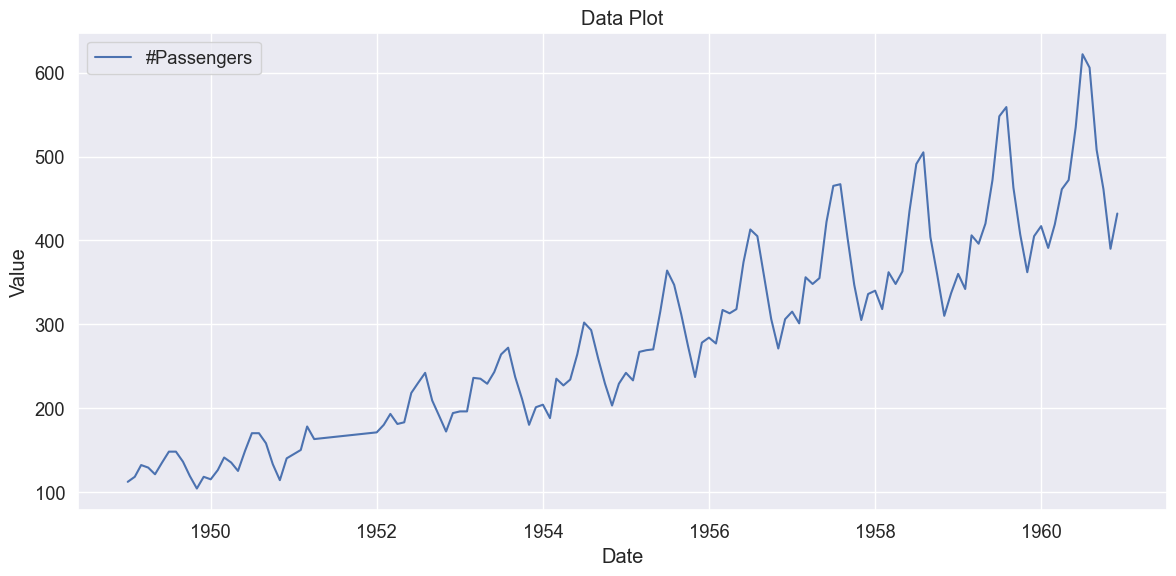

In [41]:
try:
    df = pd.read_csv("datasets/AirPassengers.csv", index_col="Date", parse_dates=True)
    print("Dataset loaded successfully.")

    # Display basic information
    print("\nDataset Information:")
    print(f"Shape: {df.shape}")
    print(f"Date Range: {df.index.min()} to {df.index.max()}")
    print(f"Columns: {', '.join(df.columns)}")
    print("\nMissing Values per Column:")
    print(df.isnull().sum())
    print(df.head(n=1))

    plt.figure(figsize=(12, 6))
    numeric_cols = df.select_dtypes(include=[np.number]).columns[:1]

    for col in numeric_cols:
        plt.plot(df.index, df[col], label=col)

    plt.title("Data Plot")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(
        "Error: 'datasets/btc.csv' not found. Please ensure the file exists in the correct directory."
    )


In [42]:
features = extract_features(df)

# Display extracted features
print("Extracted Features for Imputation:")
for key, value in features.items():
    print(f"- {key}: {value}")

# Initialize or load the imputation model selector
selector = ImputationModelSelector.load()
if not selector:
    selector = ImputationModelSelector()

if not selector.X_train:
    print("\nSelector has no prior training data.")
    selector.train()

# Get imputation model recommendation
recommended_model = selector.predict(features)

print(f"\nRecommended Imputation Model: {recommended_model}")


Extracted Features for Imputation:
- length: 136
- missing_rate: 0.0
- has_trend: 1
- has_seasonality: 0

Selector has no prior training data.
No training records available. Skipping training.
Using rule-based selection for recommendation.

Recommended Imputation Model: linear_interpolation
